## Investigation into how the shortest paths in network models change between update steps of a dynamic topology: Node Set Dynamics

In [1]:
import random 
import itertools
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt 

**Graph Creation Method**
Graph Type: Small World (Watts Strogatz)

In [2]:
# Return every adjacent pair / edge in the ring lattice 
#       structure 
# Enumerate the edges in a ring lattice of degree k 
# nodes: Range/set of nodes in ring
# k: Number of neighbours of each node 
# return: List of edges as tuples (i, j)
def ring_adjacents(nodes, k):
    hk = int(np.floor(k / 2))
    
    edges = []
    for node in nodes:
        # Identify each adjacent node 
        for j in range((node + 1), (node + hk + 1)):
            v = nodes[j % len(nodes)]  # Modulo enforces loop back to start node  
            edges.append((node, v))
    
    return edges


# Create a networkx regular ring lattice network 
# n: Number of nodes
# k: Number of neighbours of each node
# return: Regular ring lattice as networkx graph 
def ring_network(n, k):
    nodes = range(n)
    edges = ring_adjacents(nodes, k)
    
    # Create networkx graph 
    G = nx.Graph()
    G.add_nodes_from(nodes)
    G.add_edges_from(edges)
    
    return G


# Watts-Strogatz Algorithm: Randomly rewire edges of given graph
# Graph expected is a regular ring lattice n, k 
# With given probability, p, each edge is randomly assigned a new destination
# G: Graph to rewire (networkx)
# p: Probability to rewire edge
def ws_rewire(G, p):
    for i, j in G.edges():
        if random.random() < p:
            G.remove_edge(i, j)
            nodes = [n for n in list(G.nodes) if n != i  and n not in G[i]]
            # Create new edge
            u, v = i, random.choice(nodes)
            G.add_edge(u, v)

            
# Generate a networkx graph with small world properties (Watts-Strogatz)     
def watts_strogatz(n, k, p):
    # Generate the edge list of a ring lattice 
    #     of size n and degree k 
    ring = ring_network(n, k)
    
    # Randomly reassign edges with probability p
    ws_rewire(ring, p)
    
    return ring

**Node Set Dynamics:**  Below is the implementation of the function(s) to modify the node set of a given graph for one time step. This is achieved by re-wiring edges to a new uniformly selected destination node with a given probability. 

In [37]:
def dynamic_step_NODE(G, Pr, minw = 0, maxw = 100):
    removed = []
    G_ = G.copy()
    
    reconnect = []
    # Randomly remove nodes
    for node in list(G_.nodes()):
        if random.random() < Pr:
            # Check if any nodes need to be reconnected
            for j in G_[node]:
                if G_.degree[j] == 1:
                    reconnect.append(j) 
            
            G_.remove_node(node)
            removed.append(node)
    
    # Reconnect lonely, disconnected nodes 
    for j in reconnect:
        if j in G_.nodes():
            i = np.random.choice(G_.nodes())
            G_.add_edge(j, i, weight = random.uniform(minw, maxw))
        
    return (G_, removed) 

**Utility Functions (Run all)**

In [4]:
# Randomly assign edge weights in range to graph
def assign_random_weights(G, wmin, wmax, w):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = np.random.uniform(low=wmin, high=wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w

In [5]:
# Compute the shortest paths between all pairs of nodes
# in a weighted, undirected networkx graph 
# Djiksta's algorithm 
def nx_dijkstra(G, source):
    q = []        # Queue nodes to visit in traversal 
    dist = {}     # Distances from source
    prev = {}     # Previous node in path
    
    # Initialise distances to infinity 
    for node in list(G.nodes):
        dist[node] = float('inf')
        prev[node] = None 
        q.append(node) # Queue node for visiting 
        
    dist[source] = 0
    
    while q:
        # Take the node in q with the minimum distance from source
        min_ind, du = None, float('inf')
        for ind, node in enumerate(q):
            if dist[node] < du:
                min_ind, du = ind, dist[node]
        
        # Change u from index to node value
        # Remove u from q 
        u = q.pop(min_ind)
        
        # For every neighbour of u in q
        for v in list(G[u]):
            if v not in q:
                continue 
            
            alt = dist[u] + G[u][v]['weight']
             
            # Select the shortest path to v
            if alt < dist[v]:
                dist[v] = alt
                prev[v] = u
            
    return dist, prev

In [6]:
# Function to calculate Djikstra's shortest path (distances and paths)
# between all pairs of nodes (node n is source for every node n in G)
def all_shortest_paths(G):
    distances = []
    paths = []
    
    for src in list(G.nodes):
        d, p = nx_dijkstra(G, src)
        
        distances.append(d)
        paths.append(p)
    
    return distances, paths

In [7]:
# Function to calculate the average path length 
# The is the mean of all the shortest paths between 
#     all pairs of vertices 
# The shortest paths are calculated using Djikstra's deterministic algorithm 
def average_path_length(G):
    total_length = 0.0 
    
    # For every source node 
    for src in list(G.nodes):
        # Calculate the shortest path to all other nodes 
        d, p = nx_dijkstra(G, src)
        
        # Add each path length to the total
        total_length += sum(d.values())
    
    # Shortest paths were computed for n(n-1) pairs of nodes
    # Calculate mean path length
    return (total_length / (G.number_of_nodes() * (G.number_of_nodes() - 1)))

In [8]:
def get_new_ws_graph(n, k, p, minw, maxw):
    G = watts_strogatz(n, k, p)
    assign_random_weights(G, minw, maxw, None)
    
    return G

In [9]:
# Given two Dijksta's previous-node lists from source src 
# Calculate how many of the paths between the two differ or have changed
# This is not as trivial as it first seems; for previous-node changed,
# subsequent nodes traversed via the effected node also have their
# paths changed
# Effected nodes are added to a queue and subsequent nodes identified until
# all changed paths have been accounted for 
def count_changed_paths(pt, pt_):
    paths_changed = 0
    
    effected_node_queue = [] 
    for (k, v), (k_, v_) in zip(pt.items(), pt_.items()):
        if v != v_:
            effected_node_queue.append(k_)
            
            # Look for subsequently effected nodes
            while effected_node_queue:
                paths_changed += 1 # Increment paths changed 
                n = effected_node_queue.pop(0)
                
                # For each path 
                for (q, p) in pt_.items():
                    # If the previous node in path to q is k_ 
                    if p == n:
                        # Then add q as an effected node, as its path has changed 
                        effected_node_queue.append(q)
        
    return paths_changed

**Analysis**

For a range of probability values, how many shortest paths are changed at each time step? 
For a range of probability values, how does the average shortest path length change with each time step? 

In [54]:
# Calculate the shortest paths for ts time steps over a range of probabilities 
Pr_range = [0.01, 0.05, 0.1]
ts = 100

# Outputs from Dijkstra: Distances from source; previous nodes in path from source 
distances = []
paths = []

# Track nodes removed at each time step 
removed = []

# Set up an initial graph 
G_ = get_new_ws_graph(250, 10, 0.1, 0, 100)

# For each probability parameter
for Pr in Pr_range:
    ts_paths = []
    ts_removed = []
    ts_distances = []
    
    G, nodes = G_.copy(), []
    # Simulate over time steps
    for t in range(ts): 
        # Calculate djikstra's for all sources 
        d, p = all_shortest_paths(G)
        
        ts_paths.append(p)
        ts_distances.append(d)
        ts_removed.append(nodes)
        
        # Retrieve modified graph 
        G, nodes = dynamic_step_NODE(G_, Pr)
    
    paths.append(ts_paths)
    removed.append(ts_removed)
    distances.append(ts_distances)

In [80]:
# Algorithm to determine how many paths have changed at each time step 
paths_changed = []

# For each probability value tested 
for i, p in enumerate(removed):
    ts_paths_changed = []
    
    # For each time step from T=1, after first change 
    for j, t in enumerate(p[1:]):
        if not t: 
            # Zero paths changed 
            ts_paths_changed.append(0)
            continue 
        
        changed_count = 0
        # How many shortest paths are affected by 
        #    the removal of nodes?
        for node_removed in t:
            # How many paths in the previous time step 
            # required traversal of a removed node? 
            sp = paths[i][j]
            
            for src in sp:
                q = [node_removed]
                
                while q:
                    nxt = q.pop(0)
                    
                    for (key, prev) in src.items():
                        if prev == nxt:
                            q.append(key)
                            changed_count += 1 
        
        ts_paths_changed.append(changed_count)
        
    paths_changed.append(ts_paths_changed)


0
1
2


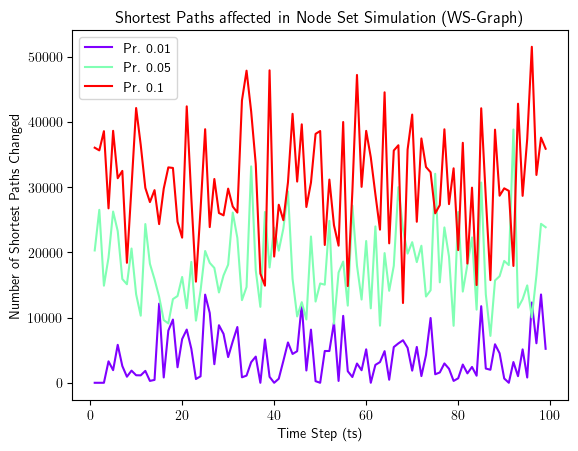

In [91]:
# Plot of number of paths changed over time 
x = range(1, ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    plt.plot(x, paths_changed[i], color = colours[i], label = ("Pr. " + str(Pr_range[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Number of Shortest Paths Changed")
plt.title("Shortest Paths affected in Node Set Simulation (WS-Graph)")
plt.show() 

fig.savefig('NS_ex1_paths.jpg')

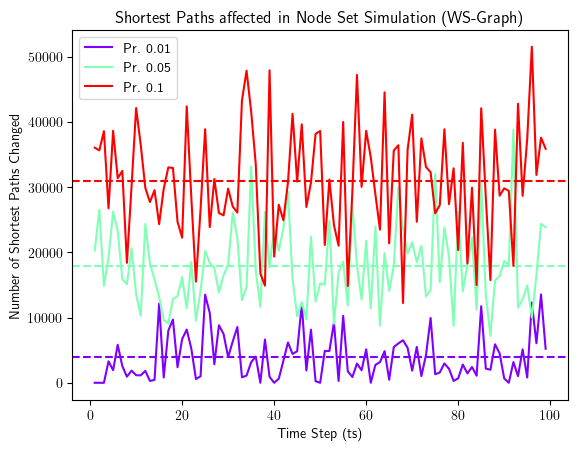

In [90]:
# Plot of number of paths changed over time 
x = range(1, ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    m = np.mean(paths_changed[i])
    plt.plot(x, paths_changed[i], color = colours[i], label = ("Pr. " + str(Pr_range[i])))
    plt.axhline(y = m, color = colours[i], linestyle = 'dashed')

plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Number of Shortest Paths Changed")
plt.title("Shortest Paths affected in Node Set Simulation (WS-Graph)")
plt.show() 

fig.savefig('NS_ex1_paths_mean.jpg')

In [92]:
# Get mean paths changed for each probability to drop out nodes 
for i in range(len(Pr_range)):
    print("Mean for Pr = ", Pr_range[i], ": ", np.mean(paths_changed[i]))

Mean for Pr =  0.01 :  3908.4343434343436
Mean for Pr =  0.05 :  17893.828282828283
Mean for Pr =  0.1 :  30951.484848484848


Plot the distribution of the number of paths changed on each time step, for each probability parameter.

<Figure size 640x480 with 0 Axes>

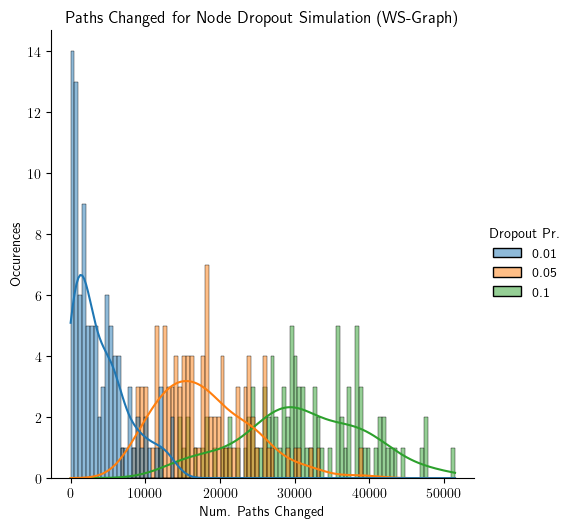

In [108]:
import seaborn as sns

dic = {Pr_range[0]: paths_changed[0], Pr_range[1]: paths_changed[1], Pr_range[2]: paths_changed[2]}

fig = plt.figure()
ax = sns.displot(data = dic,  kde=True, bins=100)
ax.set(xlabel='Num. Paths Changed', ylabel='Occurences')
ax._legend.set_title("Dropout Pr.")
plt.title("Paths Changed for Node Dropout Simulation (WS-Graph)")
plt.show()

fig.savefig("NS_ex2_all_displot.jpg")

<Figure size 640x480 with 0 Axes>

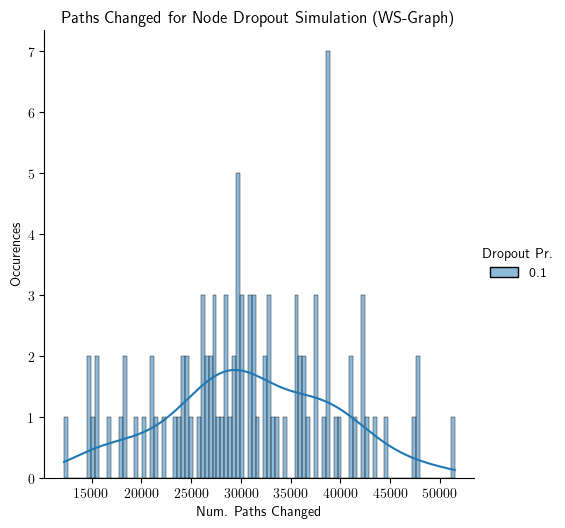

In [111]:
fig = plt.figure()

ax = sns.displot(data = {Pr_range[2]: paths_changed[2]},  kde=True, bins=100)
ax.set(xlabel='Num. Paths Changed', ylabel='Occurences')
ax._legend.set_title("Dropout Pr.")
plt.title("Paths Changed for Node Dropout Simulation (WS-Graph)")
plt.show()

fig.savefig("NS_ex2_normal_displot.jpg")

In [112]:
pathlengths = []

for d_pr in distances:
    ts_pathlengths = []
    # Find the average pathlength at each time step
    for dts in d_pr:
        paths = 0
        total_pathlength = 0.0 
        
        # Find average path length based on output from Dijkstra's
        for dsrc in dts:
            paths += 1 
            total_pathlength += sum(dsrc.values()) 
        
        avg_pathlength = total_pathlength / paths
        ts_pathlengths.append(avg_pathlength)
    
    pathlengths.append(ts_pathlengths)

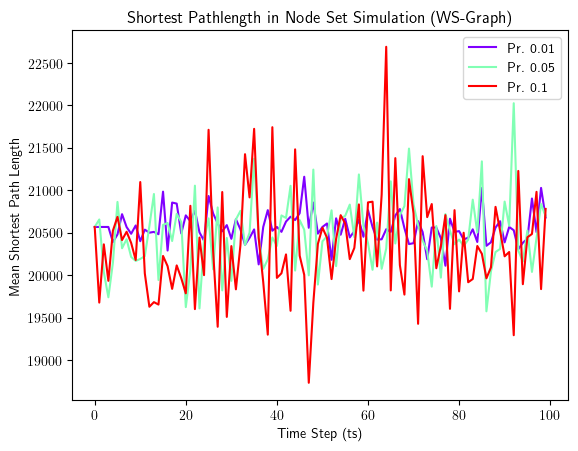

In [116]:
x = range(ts)
colours = plt.cm.rainbow(np.linspace(0, 1, len(Pr_range)))

fig = plt.figure()
for i in range(len(Pr_range)):
    plt.plot(x, pathlengths[i], color = colours[i], label = ("Pr. " + str(Pr_range[i])))
plt.legend()
plt.xlabel("Time Step (ts)")
plt.ylabel("Mean Shortest Path Length")
plt.title("Shortest Pathlength in Node Set Simulation (WS-Graph)")
plt.show() 

fig.savefig('NS_ex3_avg_length.jpg')